In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import optuna
from tqdm.notebook import tqdm
import torchvision

## CNN CLASSIFICATION

In [2]:
class CNNDataset(Dataset):

    def __init__(self, Dataset):
        
        self.transform = torchvision.transforms.ToTensor()
        # Read the file and store the content in a pandas DataFrame
        self.ds = Dataset

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds[idx]
        out = (self.transform(row[0]) , row[1])
        return out
    
def Kfold(i,s):
    ind = i.copy()
    np.random.shuffle(ind)
    fold = np.array_split(ind,s)
    K = []
    k = [i for i in range(s)]
    for i in k:
        app = k.copy()
        app.pop(i)
        app2 = np.concatenate([fold[j] for j in app])
        K.append([app2,fold[i]])
    return K

In [3]:
class CNN(nn.Module):
    def __init__(self, params):#Ni, Nh1, Nh2, Nh3, No):
        
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        Nh3 - Neurons in the 2nd hidden layer
        No - Output size
        
        lr - learning rate
        opt - optimizer
        """
        super().__init__()
        
        #print('Network initialized')
        self.net = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, params['Ch1'], 4, padding = 1), #28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 14 x 14
            nn.Conv2d(params['Ch1'] , params['Ch2'], 5, padding = 1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 7 x 7
            nn.Flatten(),
            nn.Linear(in_features=params['Ch2']*5*5 ,out_features=params['Nh1']), 
            nn.Sigmoid(), 
            nn.Linear(in_features=params['Nh1'], out_features=params['Nh2']),
            nn.Sigmoid(),
            nn.Linear(in_features=params['Nh2'], out_features=10))
        
        self.optimizer = getattr(optim, params['optimizer'])(self.net.parameters(), 
                                                        lr= params['lr'], weight_decay = params["weight"])
        self.loss_f = nn.CrossEntropyLoss()
        
        self.val_loss = []
        self.train_loss = []
        self.params = params

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x):
        return self.net(x)

    # Training_step defines the training loop. 
    def train(self, epochs, train_dataloader,val_dataloader,reset = False):

        pbar = tqdm(range(epochs),desc = 'Train loss: ',leave=False)
        for e in pbar:
            train_loss = []
            for x,y in train_dataloader:
                
                #forward
                out = self.forward(x)
                
                #loss
                loss = self.loss_f(out,y)
                
                #backprop
                self.net.zero_grad()
                loss.backward()
                
                #optimizer
                self.optimizer.step()
                
                train_loss.append(loss.detach())
            
            self.train_loss.append(np.mean(train_loss))
            
            val_loss = []
            with torch.no_grad():
                for s in val_dataloader:
                    x = s[0]
                    y = s[1]
                    
                    #forward
                    out = self.forward(x)
                    
                    #loss
                    loss = self.loss_f(out,y)
                    
                    val_loss.append(loss.detach())
                
            self.val_loss.append(np.mean(val_loss))
            pbar.set_description('Val loss: ' + str(self.val_loss[-1])[:4])

    
def KTrain(params, epochs, train_df, k):
    val_loss = []
    for fold in tqdm(Kfold(np.arange(len(train_df)),k) ,desc= "Fold", leave = False):
        
        train_data = torch.utils.data.Subset(train_df, fold[0])
        val_data = torch.utils.data.Subset(train_df, fold[1])

        batch_size = 1_000
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=3)
        val_dataloader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
        
        net = CNN(params)
        net.train(epochs, train_dataloader, val_dataloader)
        
        val_loss.append(net.val_loss[-1])
        
    return val_loss

## DATASET

In [4]:
train_dataset = CNNDataset(torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True))
test_dataset  = CNNDataset(torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True))

In [5]:
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
"Shirt", "Sneaker", "Bag", "Ankle boot"]

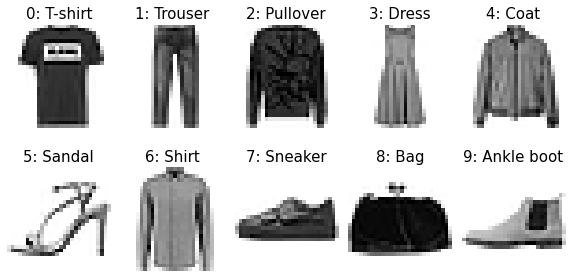

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(10,5))
c = 0
for i,a in enumerate(axs.flatten()):
    while train_dataset[c][1] != i:
        c += 1
    a.imshow((-1)*train_dataset[c][0].detach()[0], cmap="gray")
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(str(i) + ": " + labels[i], fontsize = 15)
    a.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig("img/clothes_imgs.png", dpi=300)

In [6]:
batch_size = 200
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=3)

## FIRST CLASSIFICATION

In [8]:
params = {
    'Ch1': 5,
    'Ch2': 12,
    'Nh1' : 20,
    'Nh2' : 20,
    'lr'  : 1e-2,
    'optimizer': 'Adam',
    'weight': 10**(-3)
    }


net = CNN(params)
epochs = 10
net.train(epochs, train_dataloader, test_dataloader)
print("DONE")
print("Test error = ", net.val_loss[-1])

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

DONE
Test error =  0.38133672


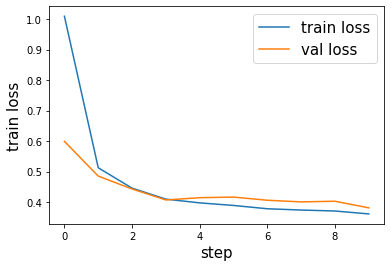

In [9]:
plt.plot(net.train_loss, label = "train loss")
plt.plot(net.val_loss, label = 'val loss')
plt.xlabel('step',fontsize=15)
plt.ylabel('train loss',fontsize=15)

plt.legend(fontsize = 15)

In [10]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')


Accuracy of the network on the test images: 86 %


## HYPERPARAMETER OPTIMIZATION

In [12]:
torch.manual_seed(201098)  

def objective(trial):
    # Parameters
    params = {
    'Nh1' : trial.suggest_int('Nh1', 20,50),
    'Nh2' : trial.suggest_int('Nh2', 20,50),
    'Ch1' : trial.suggest_int('Ch1', 4,10),
    'Ch2' : trial.suggest_int('Ch2', 10,15),
    'lr'  : trial.suggest_loguniform('lr', 1e-4, 1e-2),
    'weight'  : trial.suggest_loguniform('weight', 1e-4, 1e-1),
    'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    }
    epochs = 10
    val_loss = KTrain(params, epochs, train_dataset, 3)
    
    return np.mean(val_loss)

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=10)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-05 14:21:34,451] A new study created in memory with name: myfirstoptimizationstudy


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 14:26:41,990] Trial 0 finished with value: 2.3033387660980225 and parameters: {'Nh1': 23, 'Nh2': 32, 'Ch1': 7, 'Ch2': 14, 'lr': 0.001751326955876277, 'weight': 0.03706933515034792, 'optimizer': 'Adam'}. Best is trial 0 with value: 2.3033387660980225.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 14:37:09,442] Trial 1 finished with value: 0.9601842761039734 and parameters: {'Nh1': 21, 'Nh2': 21, 'Ch1': 9, 'Ch2': 15, 'lr': 0.0017382745985663856, 'weight': 0.0031699078621033184, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.9601842761039734.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 14:42:26,107] Trial 2 finished with value: 2.3269615173339844 and parameters: {'Nh1': 47, 'Nh2': 37, 'Ch1': 8, 'Ch2': 14, 'lr': 0.000667014070243367, 'weight': 0.030689560193764908, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.9601842761039734.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 14:50:21,496] Trial 3 finished with value: 2.3031718730926514 and parameters: {'Nh1': 24, 'Nh2': 26, 'Ch1': 9, 'Ch2': 12, 'lr': 0.002332336644481059, 'weight': 0.03286755521558747, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.9601842761039734.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 14:54:51,035] Trial 4 finished with value: 2.3182015419006348 and parameters: {'Nh1': 37, 'Nh2': 49, 'Ch1': 4, 'Ch2': 14, 'lr': 0.00042563404475744855, 'weight': 0.00022360073478983644, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.9601842761039734.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 15:00:06,903] Trial 5 finished with value: 2.3083574771881104 and parameters: {'Nh1': 36, 'Nh2': 28, 'Ch1': 8, 'Ch2': 14, 'lr': 0.00372121069813354, 'weight': 0.04923562686086417, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.9601842761039734.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 15:07:03,743] Trial 6 finished with value: 1.6974897384643555 and parameters: {'Nh1': 35, 'Nh2': 22, 'Ch1': 9, 'Ch2': 14, 'lr': 0.000295077129561728, 'weight': 0.0023170736238445028, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.9601842761039734.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 15:11:32,776] Trial 7 finished with value: 0.3791445791721344 and parameters: {'Nh1': 38, 'Nh2': 28, 'Ch1': 4, 'Ch2': 12, 'lr': 0.007606565664582346, 'weight': 0.00010982146325443392, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.3791445791721344.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 15:19:03,871] Trial 8 finished with value: 1.5635662078857422 and parameters: {'Nh1': 45, 'Nh2': 26, 'Ch1': 10, 'Ch2': 11, 'lr': 0.000238734539338917, 'weight': 0.0006564071794708762, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.3791445791721344.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss:   0%|          | 0/10 [00:00<?, ?it/s]

[I 2022-07-05 15:23:43,110] Trial 9 finished with value: 2.3271162509918213 and parameters: {'Nh1': 45, 'Nh2': 49, 'Ch1': 5, 'Ch2': 11, 'lr': 0.00020327096721992362, 'weight': 0.007246637762872105, 'optimizer': 'SGD'}. Best is trial 7 with value: 0.3791445791721344.


Number of finished trials: 10
Best trial:
  Value: 0.3791445791721344
  Params: 
    Nh1: 38
    Nh2: 28
    Ch1: 4
    Ch2: 12
    lr: 0.007606565664582346
    weight: 0.00010982146325443392
    optimizer: Adam


## BEST MODEL

In [10]:
best_params = {
    'Ch1': 4,
    'Ch2': 12,
    'Nh1' : 38,
    'Nh2' : 28,
    'lr'  : 0.007606565664582346,
    'optimizer': 'Adam',
    'weight': 0.00010982146325443392
    }

In [12]:
#params = trial.params
params = best_params

net = CNN(params)
epochs = 15
net.train(epochs, train_dataloader, test_dataloader)
print("DONE")
print("Test error = ", net.val_loss[-1])

Train loss:   0%|          | 0/15 [00:00<?, ?it/s]

DONE
Test error =  0.2989501


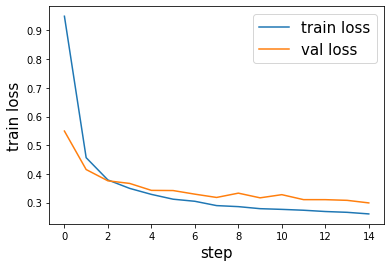

In [14]:
plt.plot(net.train_loss, label = "train loss")
plt.plot(net.val_loss, label = 'val loss')
plt.xlabel('step',fontsize=15)
plt.ylabel('train loss',fontsize=15)

plt.legend(fontsize = 15)

In [15]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 89 %


## WEIGHT HISTOGRAMS

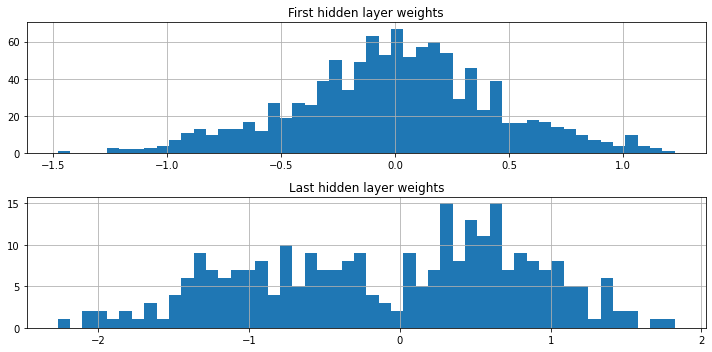

In [16]:
# First hidden layer
h1_w = net.net[9].weight.data.cpu().numpy()
h1_b = net.net[9].bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.net[11].weight.data.cpu().numpy()
h2_b = net.net[11].bias.data.cpu().numpy()


# Weights histogram
fig, axs = plt.subplots(2, 1, figsize=(10,5))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Last hidden layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig("img/weig")


## ACTIVATION 

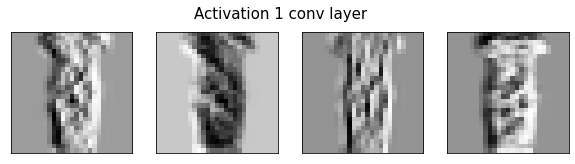

In [17]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.net[0].register_forward_hook(get_activation)

### Analyze activations

#net.eval()
with torch.no_grad():
    x1 = test_dataset[100][0].reshape(1,1,28,28)
    y1 = net(x1)
    z1 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig,ax = plt.subplots(1,z1.shape[1], figsize = (10,2.5))
for i,a in enumerate(ax):
    a.imshow(z1[0,i,:,:],cmap='Greys')
    a.set_xticks([])    
    a.set_yticks([])
fig.suptitle('Activation 1 conv layer', fontsize = 15)
plt.savefig("img/activation_conv.png", dpi =300)

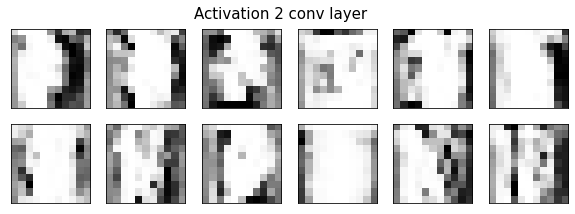

In [18]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.net[3].register_forward_hook(get_activation)

### Analyze activations

#net.eval()
with torch.no_grad():
    x1 = test_dataset[100][0].reshape(1,1,28,28)
    y1 = net(x1)
    z1 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig,ax = plt.subplots(2,6, figsize = (10,3.2))
for i,a in enumerate(ax.flatten()):
    a.imshow(z1[0,i,:,:],cmap='Greys')
    a.set_xticks([])    
    a.set_yticks([])
    
fig.suptitle('Activation 2 conv layer', fontsize = 15)
plt.savefig("img/activation_conv2.png", dpi =300)

### CONFUSION MATRIX

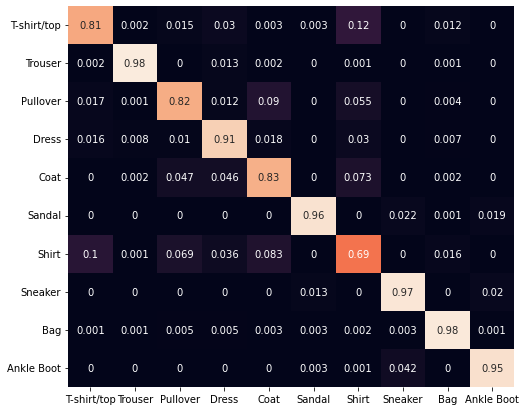

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

y_pred = []
y_true = []

for inputs, labels in test_dataloader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8,7))
sn.heatmap(df_cm, annot=True, cbar=False)
plt.savefig("img/confusion_matrix.png", dpi =300)

### Receptive fields

In [29]:
first = net.net[0].weight
first.shape

torch.Size([4, 1, 4, 4])

In [30]:
second = net.net[3].weight
second.shape

torch.Size([12, 4, 5, 5])

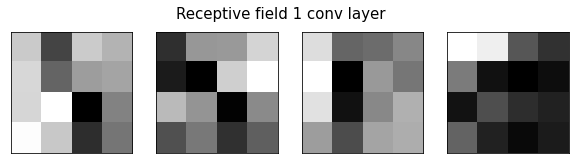

In [51]:
fig,ax = plt.subplots(1,4, figsize = (10,2.5))
for i,a in enumerate(ax.flatten()):
    a.imshow(first[i,0,:,:].detach(),cmap='Greys')
    a.set_xticks([])    
    a.set_yticks([])

fig.suptitle('Receptive field 1 conv layer', fontsize = 15)

plt.savefig("img/rec_fi_1.png", dpi =300)

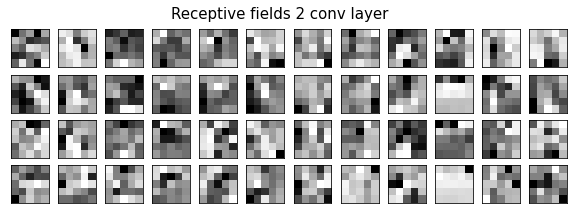

In [52]:
fig,ax = plt.subplots(4,12, figsize = (10,3.2))

for i,A in enumerate(ax):
    for j,a in enumerate(A):
        a.imshow(second[j,i,:,:].detach(),cmap='Greys')
        a.set_xticks([])    
        a.set_yticks([])
        
fig.suptitle('Receptive fields 2 conv layer', fontsize = 15)
plt.savefig("img/rec_fi_2.png", dpi =300)    